In [1]:
import sys
AUX_PATH = '/home/nata/Projects/Active/src'
if AUX_PATH not in sys.path:
    sys.path.insert(0, AUX_PATH)
import utils
import preprocessing
import models
import tournament
import features
import auxiliary

import pandas as pd
import numpy as np
import xgboost as xgb
import warnings
import matplotlib.pyplot as plt
import datetime as dt
import glob

from joblib import Parallel, delayed
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression

warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [26]:
columns = ['PGI_DATE', 'TECH_BILL_TO', 'ORDER_QUAN',
           'GI_QUAN', 'SKU', 'DISCOUNT', 'PGI_DATA', 'PROMO_ID']
ex = pd.read_csv('../data/processed/SI_simple/Uplifttool_sellin_210115.csv', sep=';', usecols = columns)
ex.head()

PGI_DATE  TECH_BILL_TO  ORDER_QUAN  GI_QUAN     SKU  PROMO_ID DISCOUNT  \
0  20200930     850090018       22.68     0.00  121032       NaN      NaN   
1  20200917     850167112       -5.40    -5.40  151712  0TA6T1M4       15   
2  20200930     850231983       38.88    38.88  158951  0TA6T3D5       23   
3  20200930     850167073       13.60    13.60  138653  0TA6T3Q6       15   
4  20200930     850244235        0.90     0.90  153810       NaN      NaN   

   PGI_DATA  
0         1  
1         1  
2         1  
3         1  
4         1

In [31]:
# ex['M'] = ex['PGI_DATE'].astype(str)[:6]
ex.groupby('PGI_DATE').agg({'ORDER_QUAN':'sum'}).tail(50)

ORDER_QUAN
PGI_DATE              
20201127  2.572903e+06
20201128  3.169882e+06
20201129  1.498951e+06
20201130  2.642846e+06
20201201  2.281161e+06
20201202  1.818659e+06
20201203  2.386698e+06
20201204  2.213490e+06
20201205  2.985195e+06
20201206  1.390582e+06
20201207  2.354357e+06
20201208  2.005919e+06
20201209  1.846149e+06
20201210  2.262063e+06
20201211  2.103851e+06
20201212  2.847603e+06
20201213  1.419076e+06
20201214  2.265348e+06
20201215  2.107114e+06
20201216  1.860145e+06
20201217  1.941634e+06
20201218  2.112850e+06
20201219  2.825869e+06
20201220  1.483339e+06
20201221  2.623822e+06
20201222  2.123796e+06
20201223  2.056430e+06
20201224  2.494246e+06
20201225  2.589769e+06
20201226  2.260392e+06
20201227  1.096915e+06
20201228  2.033808e+06
20201229  2.169862e+06
20201230  1.853796e+06
20201231  1.031886e+06
20210101  3.129512e+04
20210102  1.155540e+06
20210103  1.404704e+06
20210104  2.162626e+06
20210105  2.512658e+06
20210106  1.920910e+06
20210107  1.899100e+06
20210108  1.885779e+06
20210109  3.171886e+06
20210110  1.423474e+06
20210111  2.588080e+06
20210112  2.370625e+06
20210113  2.029957e+06
20210114  2.454649e+06
20210115  7.800000e-01

In [19]:
ex.groupby('PGI_DATE').agg({'ORDER_QUAN':'sum', 'DISCOUNT':'sum'}).tail(50)

ORDER_QUAN   DISCOUNT
PGI_DATE                           
2020-10-12  2.428884e+06   74582.43
2020-10-13  2.075967e+06   68575.14
2020-10-14  1.751963e+06   82534.12
2020-10-15  2.271177e+06   77269.76
2020-10-16  2.249639e+06   88129.43
2020-10-17  2.768980e+06   78259.38
2020-10-18  1.685777e+06   34763.43
2020-10-19  2.287335e+06   79373.50
2020-10-20  2.125748e+06   70878.20
2020-10-21  1.819310e+06   70020.67
2020-10-22  2.225588e+06   63746.59
2020-10-23  2.076845e+06   69256.20
2020-10-24  2.652345e+06   74520.02
2020-10-25  1.440415e+06   31030.23
2020-10-26  2.244138e+06   76541.44
2020-10-27  2.064451e+06   69994.90
2020-10-28  1.847574e+06   91662.49
2020-10-29  2.270458e+06   93972.43
2020-10-30  2.396548e+06  114439.43
2020-10-31  3.117181e+06  100924.27
2020-11-01  2.846530e+04    3911.79
2020-11-02  2.815874e+06  158651.53
2020-11-03  2.924518e+06  153660.52
2020-11-04  2.342001e+06  149233.85
2020-11-05  2.677839e+06  144841.28
2020-11-06  2.573265e+06  146687.56
2020-11-07  3.275275e+06  144787.59
2020-11-08  1.624017e+06   58550.49
2020-11-09  3.194726e+06  152504.08
2020-11-10  2.856306e+06  150826.59
2020-11-11  2.637416e+06  153941.07
2020-11-12  3.135989e+06  152160.23
2020-11-13  3.151555e+06  164270.58
2020-11-14  3.434587e+06  149647.49
2020-11-15  1.860868e+06   61219.08
2020-11-16  3.214254e+06  153087.72
2020-11-17  2.763623e+06  147532.06
2020-11-18  2.593937e+06  138126.01
2020-11-19  2.875983e+06  134695.62
2020-11-20  2.703209e+06  138095.84
2020-11-21  3.248180e+06  138330.84
2020-11-22  1.665368e+06   56424.73
2020-11-23  3.037929e+06  145357.54
2020-11-24  2.747631e+06  140966.32
2020-11-25  2.614735e+06  155531.03
2020-11-26  3.022463e+06  161257.62
2020-11-27  3.504459e+06  183026.52
2020-11-28  3.806545e+06  167067.30
2020-11-29  1.929930e+06   67334.66
2020-11-30  3.937943e+06  178860.77

In [14]:
ex1.groupby('Versions').agg({'KAM Volume with uplift':'sum'})

KAM Volume with uplift
Versions                          
2018-02-02            1.585097e+08
2018-02-16            2.394816e+08
2018-04-20            2.576207e+08
2018-08-06            2.472986e+08
2018-10-31            2.676264e+08
2019-02-13            2.927473e+08
2019-05-16            2.797796e+08
2019-09-05            2.729909e+08
2019-11-26            2.676557e+08
2020-01-30            2.755723e+08
2020-02-21            2.882921e+08
2020-03-23            2.897948e+08
2020-04-10            2.932739e+08
2020-05-22            3.112245e+08
2020-06-19            3.046443e+08
2020-07-27            3.058285e+08
2020-08-24            3.032301e+08
2020-09-21            2.983355e+08
2020-10-14            2.969929e+08
2020-11-23            3.008168e+08
2020-12-07            3.073201e+08

### PYATEROCHKA

In [21]:
promo = preprocessing.get_promo()
promo[promo['PROMO_ID']=='1TA7E3E4']

PROMO_ID SHIP_START  SHIP_END
328835  1TA7E3E4   20210101  20210110

739 - AV 260
45 - DM 130
301 - PR 315

In [22]:
tmp = pd.read_csv('../results/outputs/UplifttoolOutput.csv')
CHAIN = "PYATEROCHKA"
# res['FT_SHIP_START'] = np.where(res['Partition']=='train', res['SHIP_START'], res['FT_SHIP_START']) # TODO: убрать наверх
# res = res[['Date', 'key', 'Ordered', 'Partition', 'SHIP_START', 'FT_SHIP_START', 'Forecast', 'Discount on date', 'Segment']]
tmp = utils.add_cat_cust(tmp)
tmp = tmp[tmp['Chain']==CHAIN]
tmp.columns

Index(['Date', 'key', 'Ordered', 'Promo_day_num', 'Promo_day_num_backward',
       'Discount on date', 'SHIP_START', 'FT_SHIP_START', 'Y', 'M', 'W',
       'PINC', 'ON_TOP', 'ROTATION', 'count_delist_sku', 'Partition',
       'ship_to_stock', 'DC_stock', 'Profile', 'max_value_day', 'seasonal',
       'WD', 'Reg_price', 'Promo_price', 'price_discount', 'CoInvest', 'DoM',
       'DoW', 'DoY', 'HY', 'Q', 'S', 'new_year_holidays', 'lent',
       'may_holidays', 'back_to_school', 'other_holidays',
       'covid_lockdown_dates', 'big_disc', 'Forecast', 'Techbillto',
       'PRODUCT_CODE', 'Chain', 'PRD_ProdType', 'PRD_UbrellaBrand',
       'Sku/линейка'],
      dtype='object')

In [23]:
X_COLUMNS = ['Discount on date', 'Promo_day_num', 'Promo_day_num_backward', 'Y', 'M', 'W', 'DoM', 'DoW', 'DoY', 'HY',
             'Q', 'S',  # ,'Promo_day_num', 'Promo_day_num_backward'
             'PINC', 'ON_TOP', 'ROTATION', 'count_delist_sku', 'seasonal', 'Profile', 'max_value_day',
             'new_year_holidays', 'lent',
             'may_holidays', 'back_to_school', 'other_holidays', 'covid_lockdown_dates', 'ship_to_stock', 'DC_stock',
#              'cust_plan',
             'price_discount']

In [62]:
dm = tmp[tmp['PRODUCT_CODE']=='0045']

<AxesSubplot:xlabel='Date'>

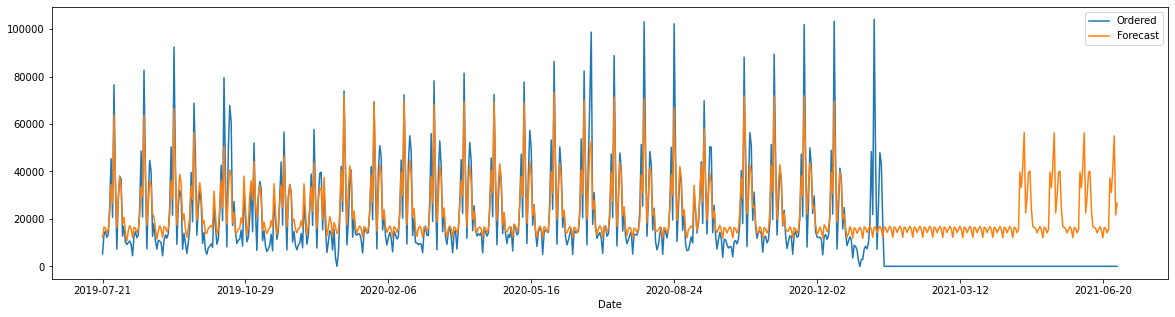

In [63]:
dm[['Date', 'Ordered', 'Forecast']].groupby('Date', as_index=False).sum().plot(x='Date', figsize=(20, 5))

In [64]:
dm.groupby('SHIP_START').agg({'Ordered':'sum', 'Forecast':'sum'})

Ordered      Forecast
SHIP_START                                   
0                    3497163.15  7.259192e+06
2019-07-26 00:00:00   327386.41  3.337236e+05
2019-08-16 00:00:00   341763.63  3.390490e+05
2019-09-06 00:00:00   339256.84  3.769380e+05
2019-09-20 00:00:00   264706.26  2.966094e+05
2019-10-04 00:00:00   100284.08  7.809737e+04
2019-10-11 00:00:00   344075.68  2.910583e+05
2019-10-25 00:00:00    63093.16  8.647647e+04
2019-11-01 00:00:00   232796.72  2.585079e+05
2019-11-15 00:00:00    68102.84  7.200463e+04
2019-11-22 00:00:00   235830.92  2.595328e+05
2019-12-06 00:00:00    62462.92  7.268955e+04
2019-12-13 00:00:00   244098.14  2.397904e+05
2019-12-20 00:00:00    69067.05  7.822339e+04
2020-01-03 00:00:00   302587.74  3.552496e+05
2020-01-24 00:00:00   340411.63  3.544438e+05
2020-02-14 00:00:00   362270.61  3.804402e+05
2020-03-06 00:00:00   361370.62  3.563592e+05
2020-03-27 00:00:00   382922.02  3.597886e+05
2020-04-01 00:00:00     1635.92  1.966881e+03
2020-04-17 00:00:00   343240.17  3.756746e+05
2020-05-08 00:00:00   416560.69  3.992249e+05
2020-05-29 00:00:00   398481.85  3.885862e+05
2020-06-19 00:00:00   490491.82  4.187599e+05
2020-07-10 00:00:00   392771.34  3.956725e+05
2020-07-31 00:00:00   420607.46  3.842066e+05
2020-08-21 00:00:00   390046.41  3.785876e+05
2020-09-04 00:00:00    69805.84  7.051250e+04
2020-09-11 00:00:00   359123.83  3.427770e+05
2020-10-09 00:00:00   416995.28  4.101768e+05
2020-10-30 00:00:00   395388.76  3.998026e+05
2020-11-20 00:00:00   434152.03  4.191871e+05
2020-12-11 00:00:00   402460.50  3.915333e+05

In [65]:
dm.groupby('FT_SHIP_START').agg({'Ordered':'sum', 'Forecast':'sum'})

Ordered      Forecast
FT_SHIP_START                                  
0                    1.287141e+07  1.537973e+07
2021-04-23 00:00:00  0.000000e+00  3.443622e+05
2021-05-14 00:00:00  0.000000e+00  3.440743e+05
2021-06-04 00:00:00  0.000000e+00  3.437864e+05
2021-06-25 00:00:00  0.000000e+00  2.128902e+05

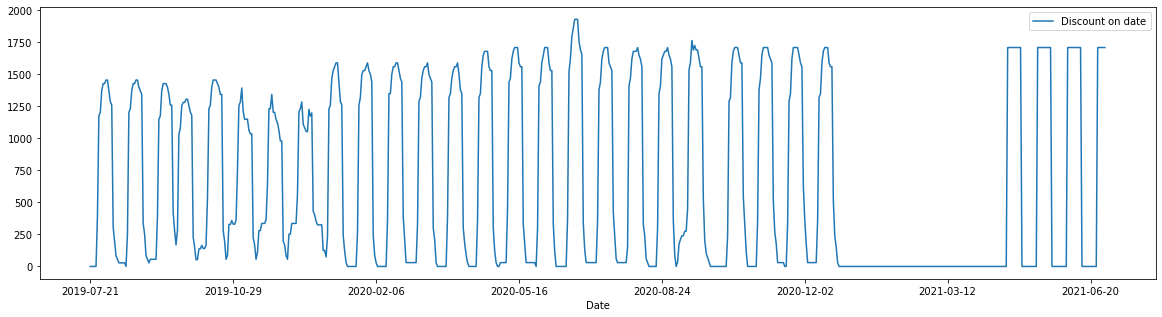

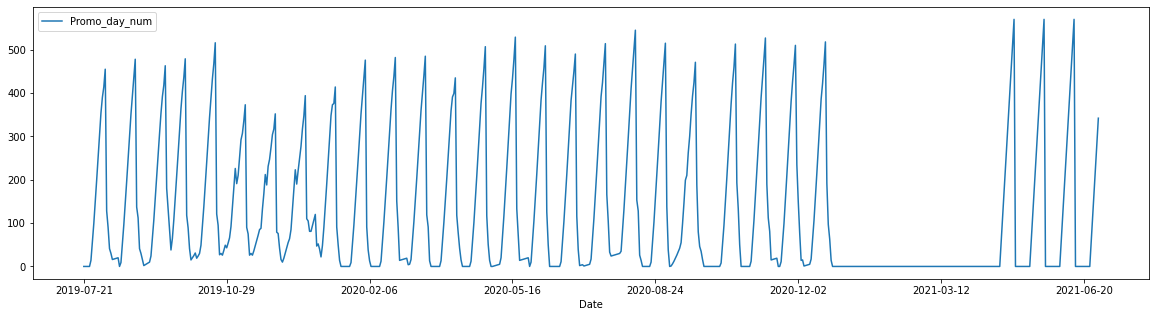

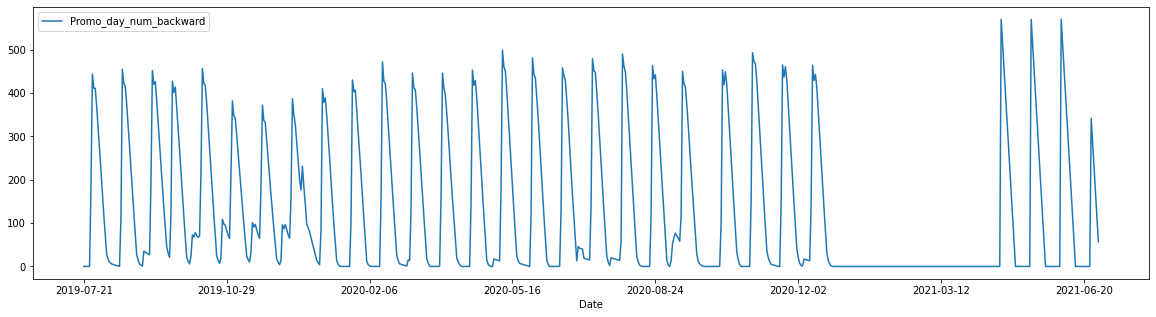

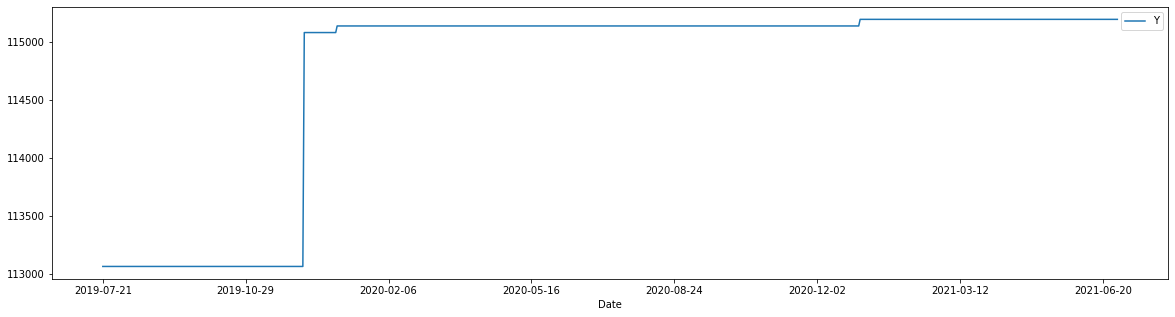

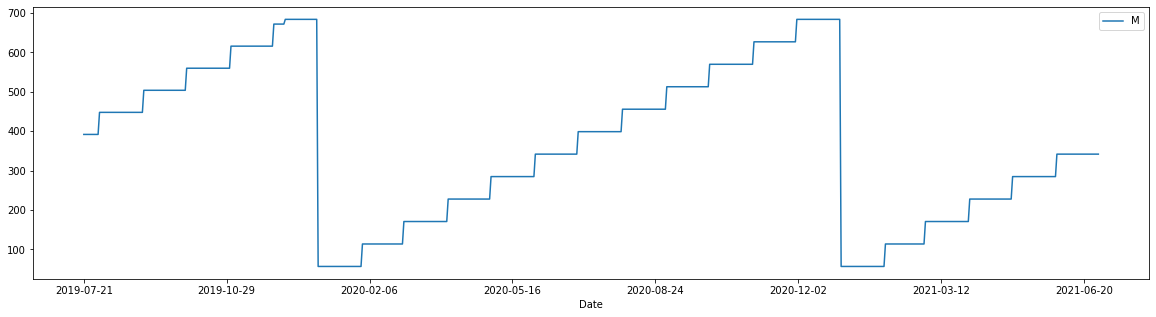

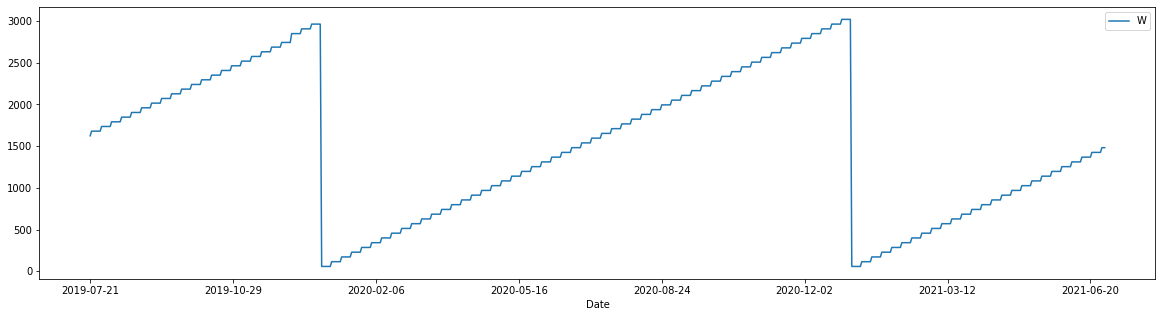

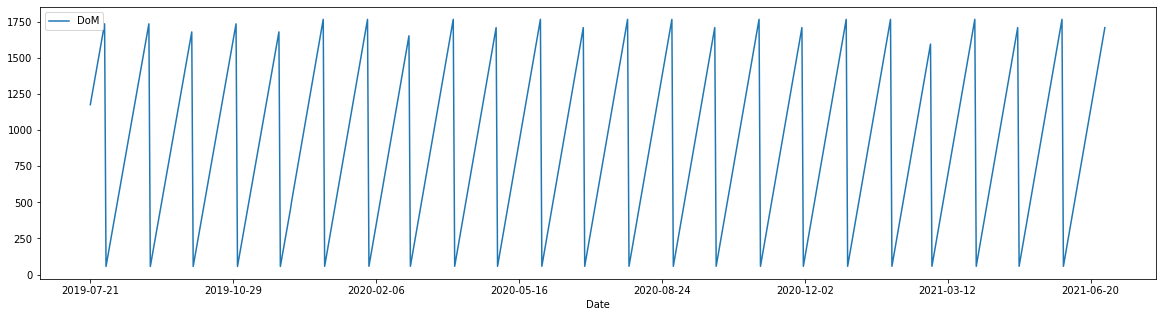

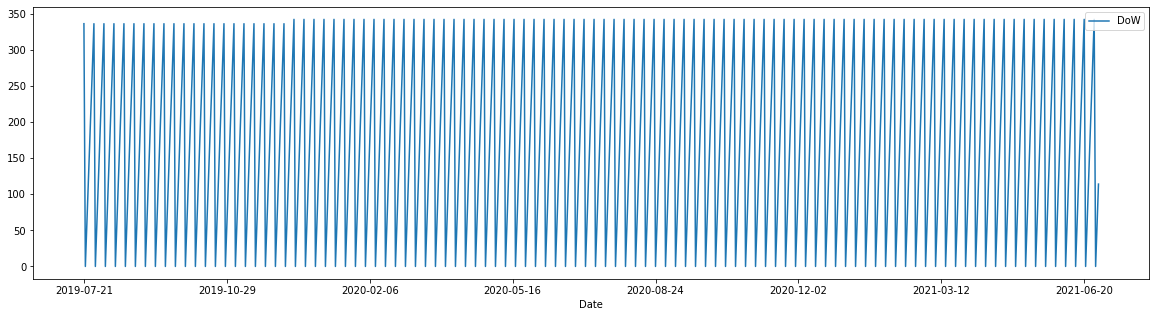

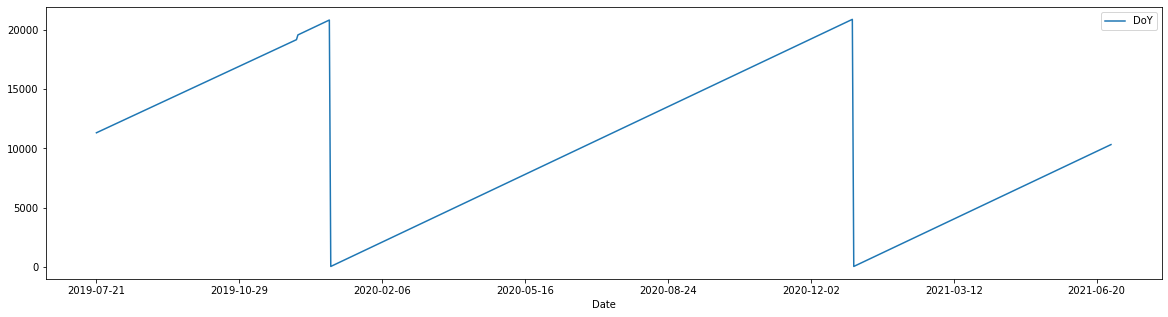

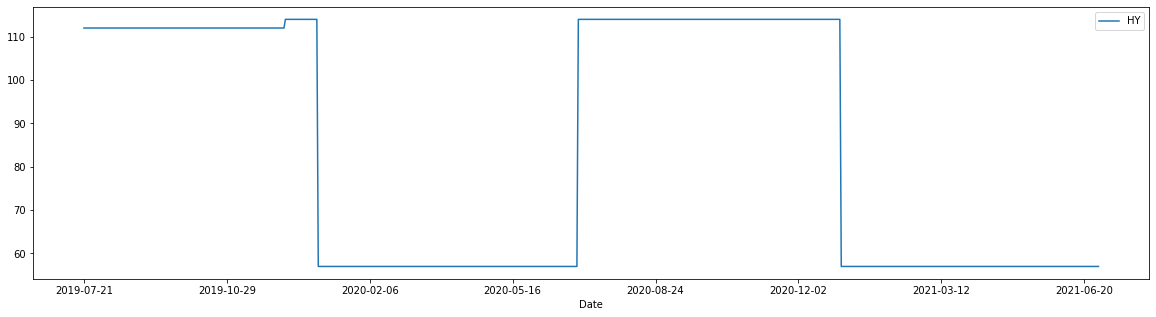

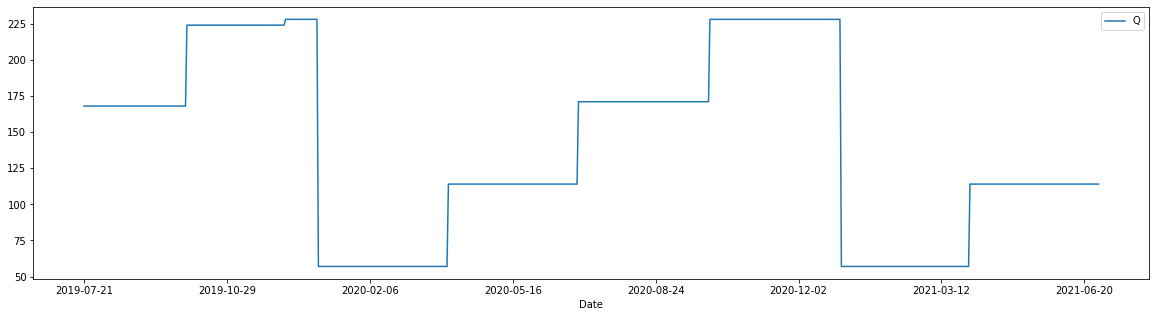

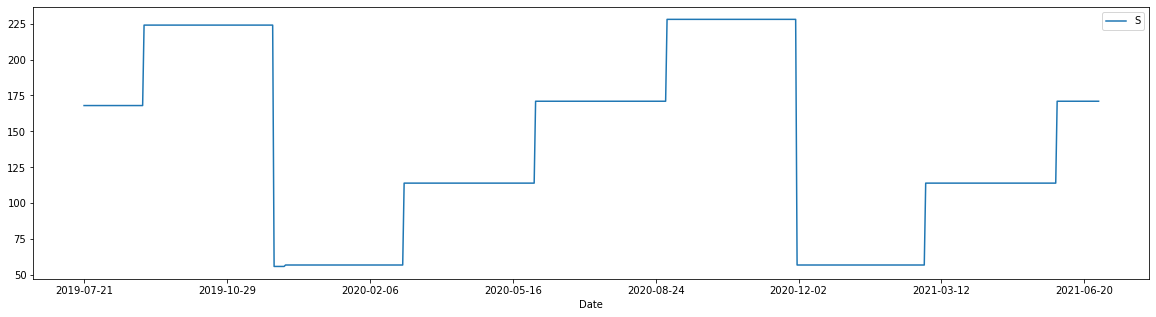

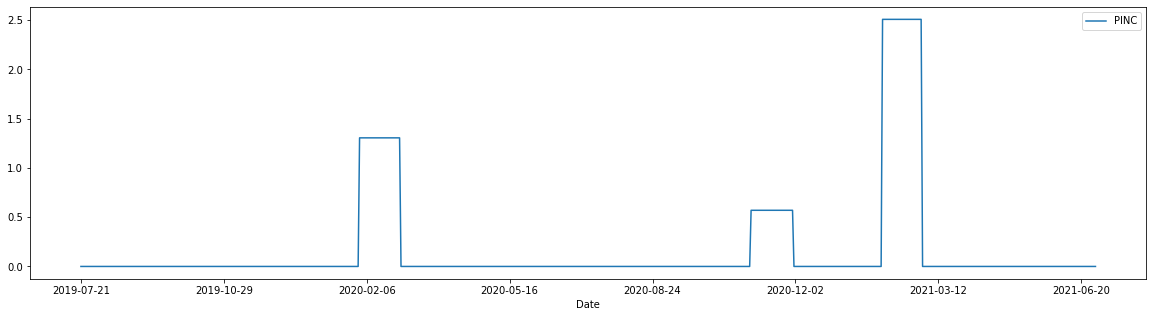

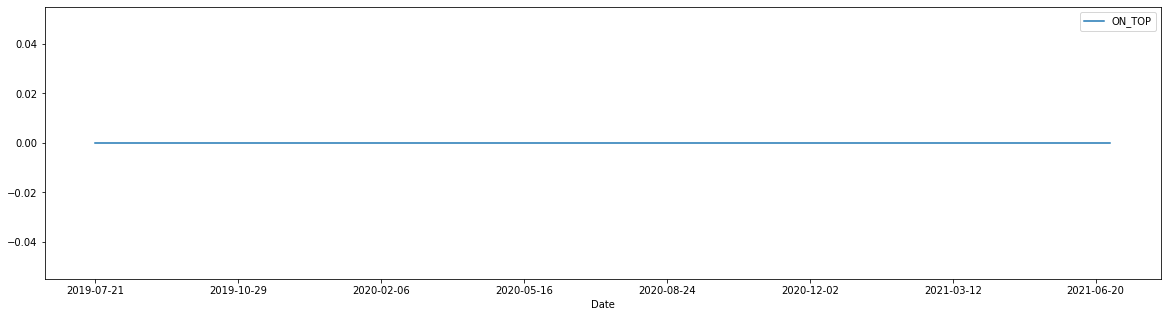

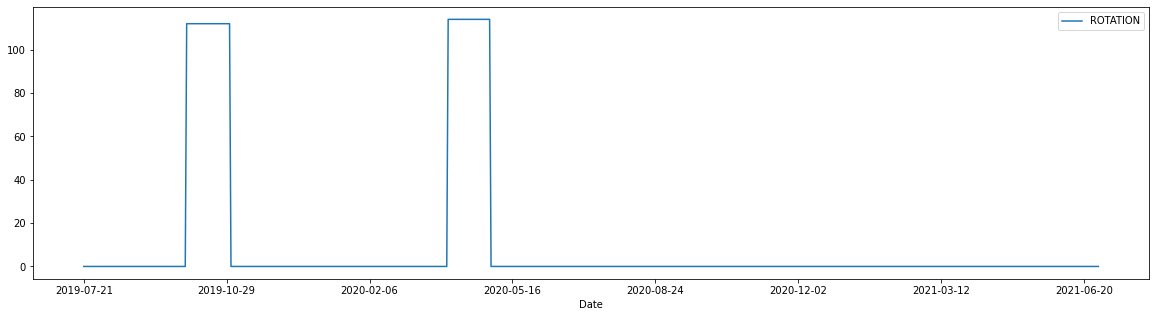

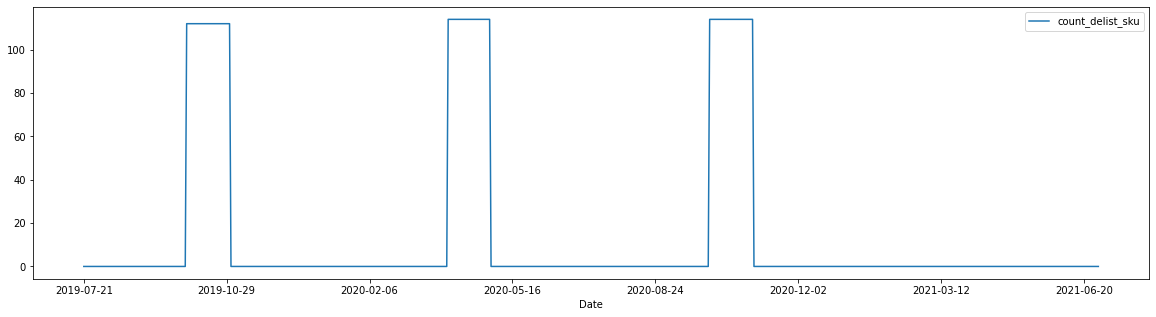

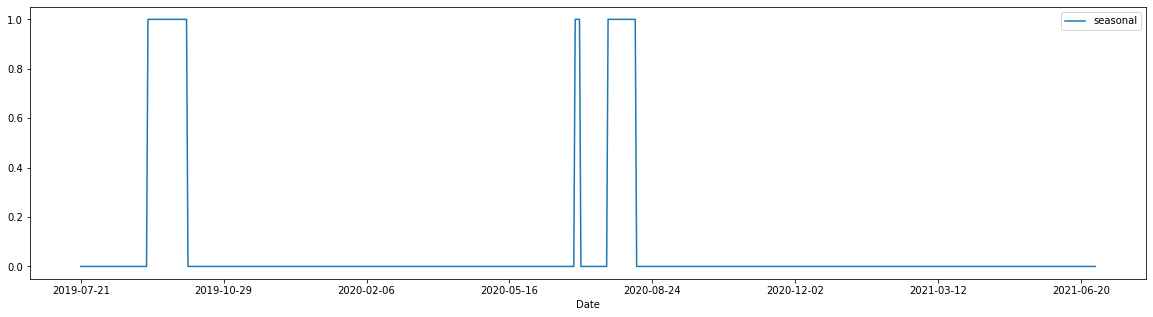

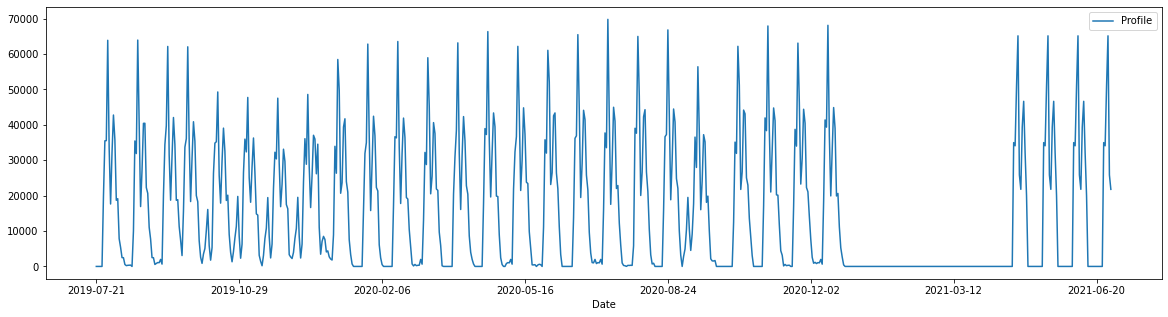

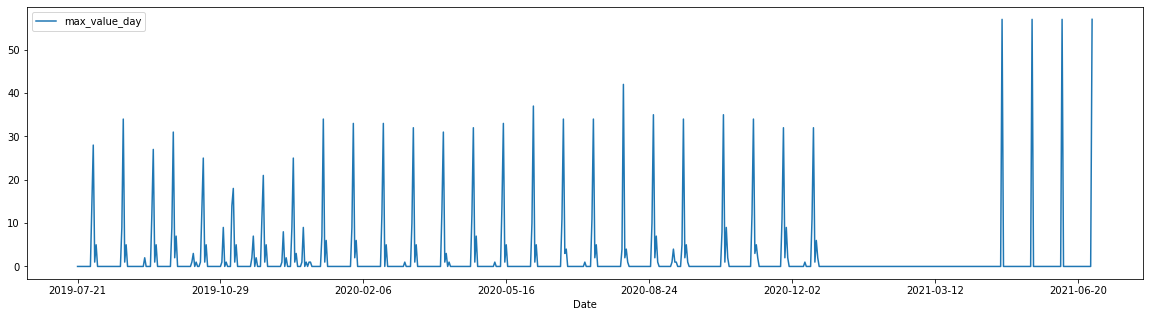

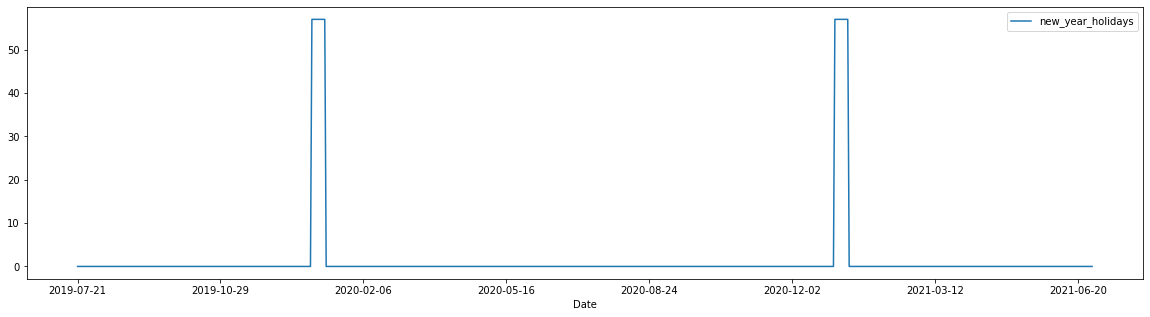

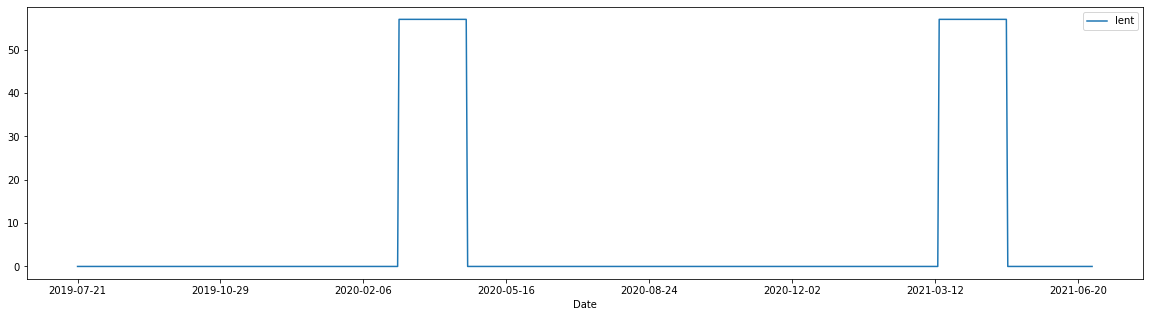

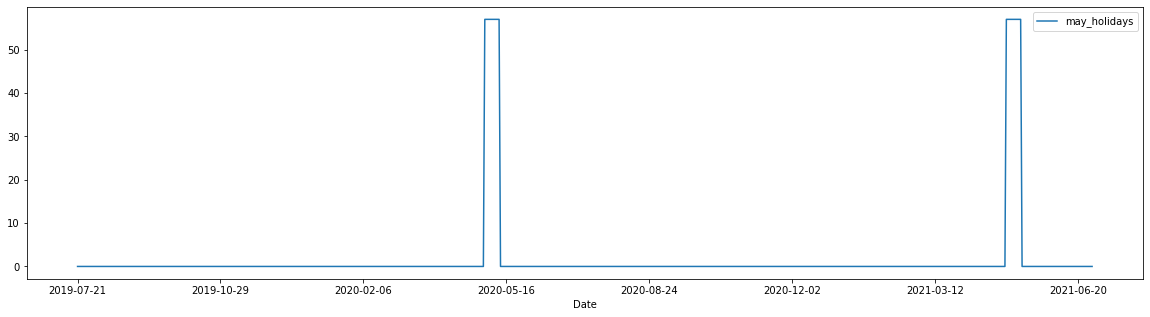

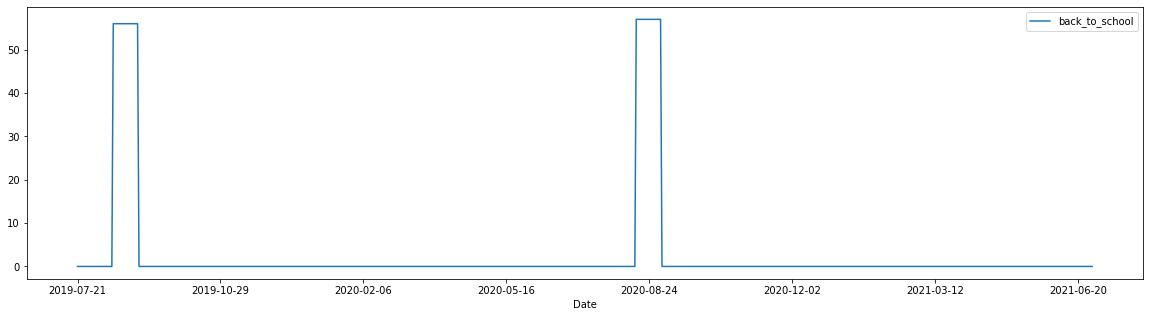

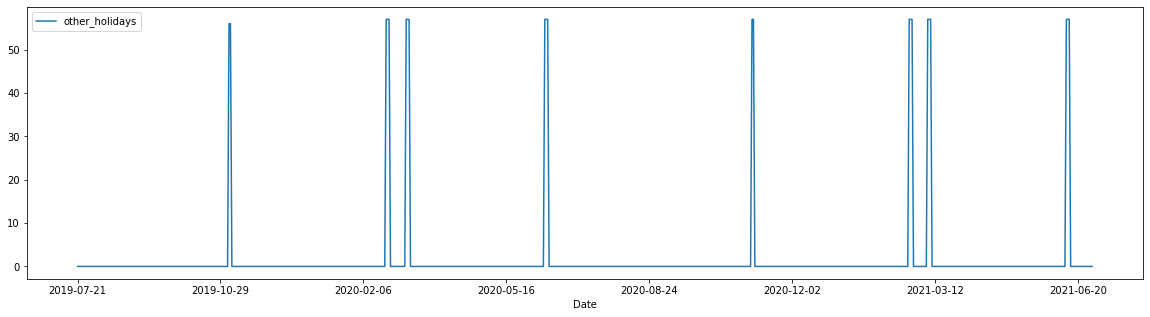

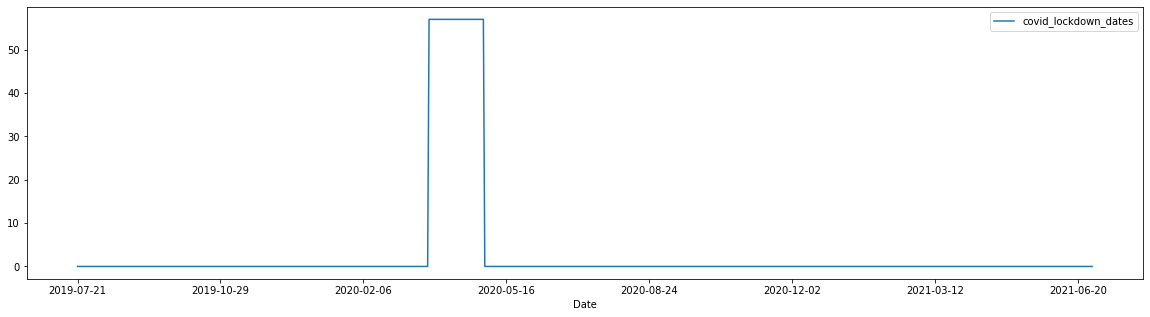

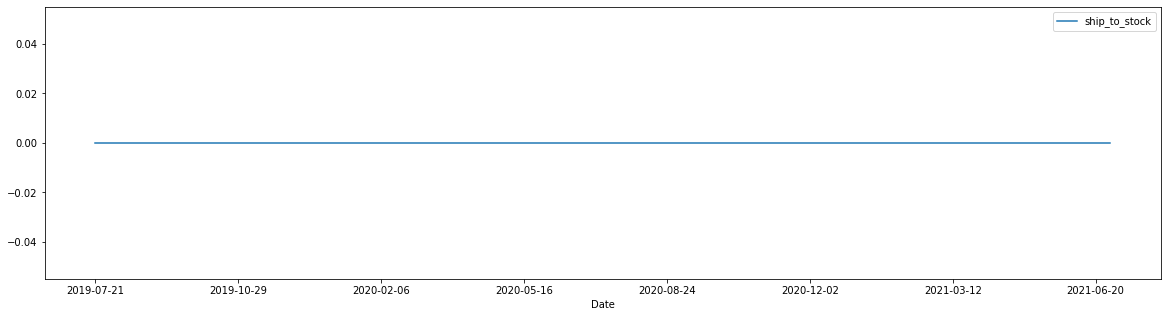

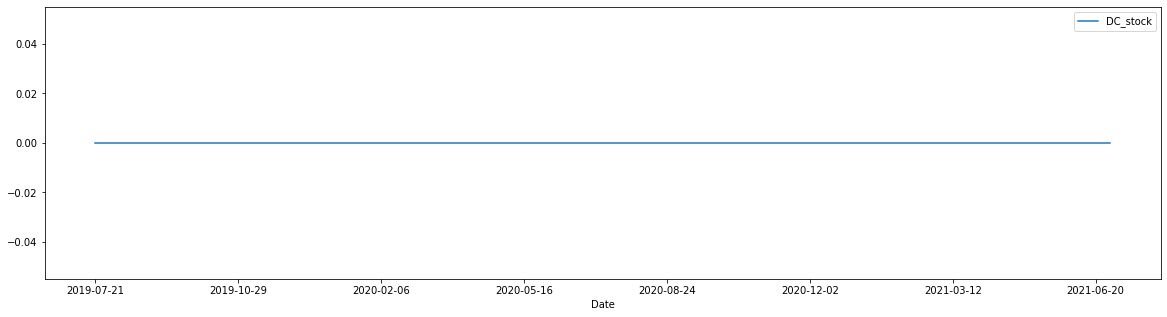

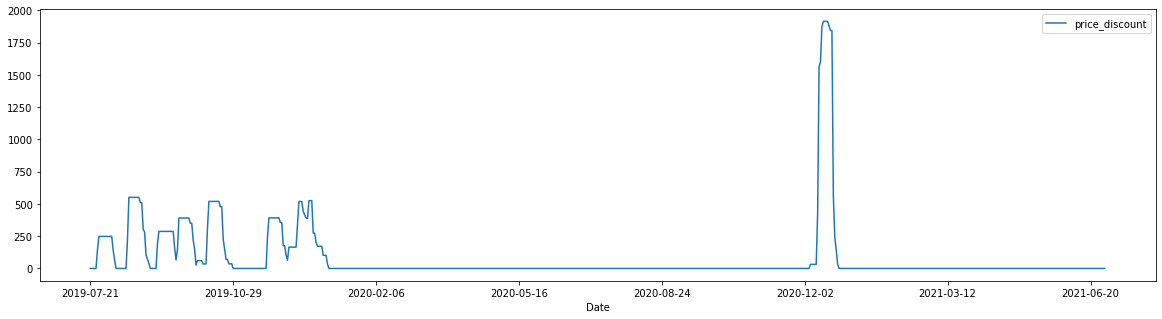

In [66]:
for col in X_COLUMNS:
    dm[['Date', col]].groupby('Date', as_index=False).sum().plot(x='Date', figsize=(20, 5))

In [16]:
dm[['SHIP_START', 'max_value_day']].groupby('SHIP_START').sum()

max_value_day
SHIP_START                        
0                              212
2019-07-26 00:00:00             48
2019-08-16 00:00:00             49
2019-09-06 00:00:00             47
2019-09-20 00:00:00             49
2019-10-04 00:00:00              6
2019-10-11 00:00:00             44
2019-10-25 00:00:00             11
2019-11-01 00:00:00             38
2019-11-15 00:00:00             11
2019-11-22 00:00:00             38
2019-12-06 00:00:00             11
2019-12-13 00:00:00             38
2019-12-20 00:00:00             13
2020-01-03 00:00:00             48
2020-01-24 00:00:00             50
2020-02-14 00:00:00             50
2020-03-06 00:00:00             49
2020-03-27 00:00:00             48
2020-04-01 00:00:00              1
2020-04-17 00:00:00             49
2020-05-08 00:00:00             50
2020-05-29 00:00:00             49
2020-06-19 00:00:00             48
2020-07-10 00:00:00             49
2020-07-31 00:00:00             49
2020-08-21 00:00:00             51
2020-09-04 00:00:00              5
2020-09-11 00:00:00             45
2020-10-09 00:00:00             51
2020-10-30 00:00:00             52
2020-11-20 00:00:00             52
2020-12-11 00:00:00             49

In [17]:
dm[['FT_SHIP_START', 'max_value_day']].groupby('FT_SHIP_START').sum()

max_value_day
FT_SHIP_START                     
0                             1248
2021-04-23 00:00:00             53
2021-05-14 00:00:00             53
2021-06-04 00:00:00             53
2021-06-25 00:00:00             53

In [18]:
dm[['Techbillto', 'Ordered']].groupby('Techbillto').sum().sort_values(by='Ordered')

Ordered
Techbillto            
850167080       527.28
850231984       725.92
850257877      1097.98
850231993      1242.80
850255825      1281.28
850167068      1376.96
850167066      1599.52
850270536      2225.60
850167079      2420.86
850250978      2899.52
850255826      3362.32
850276582      4066.66
850276583      4581.98
850167084      5214.95
850276780      5242.25
850167064      5351.84
850256321      5386.55
850231988      6226.09
850246911      7570.16
850167061      8243.30
850276584      8976.89
850255828     10211.50
850231992     10478.91
850231987     11554.79
850244238     12159.29
850255833     12373.01
850231981     12678.25
850255835     16938.22
850167081     21270.47
850255836     24022.44
850255834     25230.01
850167113     26958.10
850244237     83263.83
850255827     88573.03
850241973    100673.69
850167057    124250.88
850255831    128773.58
850167104    134281.94
850167069    158007.20
850246912    171478.58
850244236    237566.81
850255830    374963.03
850231983    385456.11
850255792    493561.90
850167089    545149.28
850167085    621410.66
850255793    645987.42
850255832    685611.16
850231990    687066.25
850231994    717458.82
850231982    726471.46
850167112   2003385.54
850255794   2406677.52

In [20]:
ex = dm[dm['Techbillto']=='850255794']
ex[ex['Partition']=='train'][['Date', 'Ordered', 'Profile', 'Promo_day_num', 'SHIP_START']].tail(50)

Date   Ordered    Profile  Promo_day_num           SHIP_START
1226581  2020-11-29  11344.32  5452.0560           10.0  2020-11-20 00:00:00
1226582  2020-11-30   5471.44  3393.3118           11.0  2020-11-20 00:00:00
1226583  2020-12-01   3235.44  2560.9966           12.0  2020-11-20 00:00:00
1226584  2020-12-02   3208.40  1966.3197           13.0  2020-11-20 00:00:00
1226585  2020-12-03   2670.98     0.0000            0.0                    0
1226586  2020-12-04   2868.32     0.0000            0.0                    0
1226587  2020-12-05   2609.36     0.0000            0.0                    0
1226588  2020-12-06   2098.72     0.0000            0.0                    0
1226589  2020-12-07   1661.92     0.0000            0.0                    0
1226590  2020-12-08   1802.32     0.0000            0.0                    0
1226591  2020-12-09   1624.48     0.0000            0.0                    0
1226592  2020-12-10   1575.60     0.0000            0.0                    0
1226593  2020-12-11   1962.48  4190.7250            1.0  2020-12-11 00:00:00
1226594  2020-12-12   4929.60  6184.6274            2.0  2020-12-11 00:00:00
1226595  2020-12-13   6853.47  9276.0090            3.0  2020-12-11 00:00:00
1226596  2020-12-14  11426.48  8482.6230            4.0  2020-12-11 00:00:00
1226597  2020-12-15   7009.60  4835.4556            5.0  2020-12-11 00:00:00
1226598  2020-12-16   2584.40  6294.1710            6.0  2020-12-11 00:00:00
1226599  2020-12-17   5653.18  9171.6640            7.0  2020-12-11 00:00:00
1226600  2020-12-18   8268.00  9896.3450            8.0  2020-12-11 00:00:00
1226601  2020-12-19   8542.56  7752.1320            9.0  2020-12-11 00:00:00
1226602  2020-12-20   7098.00  5452.0560           10.0  2020-12-11 00:00:00
1226603  2020-12-21   4461.99  3393.3118           11.0  2020-12-11 00:00:00
1226604  2020-12-22   2405.52  2560.9966           12.0  2020-12-11 00:00:00
1226605  2020-12-23   1407.12  1966.3197           13.0  2020-12-11 00:00:00
1226606  2020-12-24   1514.24     0.0000            0.0                    0
1226607  2020-12-25   1832.48     0.0000            0.0                    0
1226608  2020-12-26   1883.57     0.0000            0.0                    0
1226609  2020-12-27   1640.08     0.0000            0.0                    0
1226610  2020-12-28   1496.56     0.0000            0.0                    0
1226611  2020-12-29   1665.43     0.0000            0.0                    0
1226612  2020-12-30   1430.00     0.0000            0.0                    0
1226613  2020-12-31    127.92     0.0000            0.0                    0
1226614  2021-01-01      0.00     0.0000            0.0                    0
1226615  2021-01-02    875.68     0.0000            0.0                    0
1226616  2021-01-03    776.88     0.0000            0.0                    0
1226617  2021-01-04    828.88     0.0000            0.0                    0
1226618  2021-01-05   1082.51     0.0000            0.0                    0
1226619  2021-01-06   1179.36     0.0000            0.0                    0
1226620  2021-01-07   1192.88     0.0000            0.0                    0
1226621  2021-01-08   1374.88     0.0000            0.0                    0
1226622  2021-01-09   4343.04     0.0000            0.0                    0
1226623  2021-01-10   6404.32     0.0000            0.0                    0
1226624  2021-01-11  11007.36     0.0000            0.0                    0
1226625  2021-01-12   6829.68     0.0000            0.0                    0
1226626  2021-01-13   2613.52     0.0000            0.0                    0
1226627  2021-01-14   7044.83     0.0000            0.0                    0
1226628  2021-01-15  11008.40     0.0000            0.0                    0
1226629  2021-01-16  11010.48     0.0000            0.0                    0
1226630  2021-01-17   8416.59     0.0000            0.0                    0

In [60]:
si = pd.read_csv('../data/temp/Uplifttool_sellin210118.csv', sep=';')
si.head()

PGI_DATE  MAD_DATE  PLANT_ID                      PLANT_DESC PROXI_CATEG2  \
0  20210106  20210106      5351       5000 RU DC Volgograd 5351       R0ZR99   
1  20210106  20210105      5461         5000 RU DC Saransk 5461       R0ZR99   
2  20210106  20210105      5382  5000 RU DC Rostov-na-Donu 5382       R0V087   
3  20210105  20210104      5382  5000 RU DC Rostov-na-Donu 5382       R0ZR99   
4  20210104  20210103      5382  5000 RU DC Rostov-na-Donu 5382       R0V087   

  PROXI_CATEG2_DESC PROXI_CATEG3     PROXI_CATEG3_DESC TERR_LVL2  \
0            MAGNIT           R1  NATIONAL KEY ACCOUNT        R4   
1            MAGNIT           R1  NATIONAL KEY ACCOUNT        R4   
2         DC MAGNIT           R1  NATIONAL KEY ACCOUNT        R4   
3            MAGNIT           R1  NATIONAL KEY ACCOUNT        R4   
4         DC MAGNIT           R1  NATIONAL KEY ACCOUNT        R4   

  TERR_LVL2_DESC  ... BASE_UOM     SKU  PROMO_ID               SPEND_TYPE  \
0      RSD SOUTH  ...       KG  105975  0TA7A5X2  Off invoice, On invoice   
1      RSD SOUTH  ...       KG  105975  0TA7A5X2  Off invoice, On invoice   
2      RSD SOUTH  ...       KG  135918  0TA7A5X2  Off invoice, On invoice   
3      RSD SOUTH  ...       KG  135918  0TA7A5X2  Off invoice, On invoice   
4      RSD SOUTH  ...       KG  101184  0TA7A5Y8               On invoice   

   CONDITION DISCOUNT  REDEMPTION  PGI_DATA  MAD_DATA  REQ_DATE  
0          %     22.0    100, 100         1         0  20210106  
1          %     22.0    100, 100         1         1  20210106  
2          %     22.0    100, 100         1         1  20210106  
3          %     22.0    100, 100         1         1  20210105  
4          %     18.0         100         1         1  20210104  

[5 rows x 29 columns]

In [63]:
si.columns

Index(['PGI_DATE', 'MAD_DATE', 'PLANT_ID', 'PLANT_DESC', 'PROXI_CATEG2',
       'PROXI_CATEG2_DESC', 'PROXI_CATEG3', 'PROXI_CATEG3_DESC', 'TERR_LVL2',
       'TERR_LVL2_DESC', 'TERR_LVL3', 'TERR_LVL3_DESC', 'NFA', 'NFA_DESC',
       'RFA', 'RFA_DESC', 'TECH_BILL_TO', 'ORDER_QUAN', 'GI_QUAN', 'BASE_UOM',
       'SKU', 'PROMO_ID', 'SPEND_TYPE', 'CONDITION', 'DISCOUNT', 'REDEMPTION',
       'PGI_DATA', 'MAD_DATA', 'REQ_DATE'],
      dtype='object')

In [65]:
skus = [160268,
160269,
160270,
160271,
160272,
160273,
160274,
160275,
160276,
160277,
160278,
160485,
160586,
160589,
160592,
160593,
160594,
160595,
160596,
160597,
160598,
159221,
159222,
159223,
159224,
159226,
159214,
159215,
159217,
159218,
159219,
159220,
164854
]

In [67]:
si = si[(si['PROXI_CATEG2_DESC']=='PYATEROCHKA')&(si['PGI_DATE']==20210104)&(si['TECH_BILL_TO']==850255794)&(si['SKU'].isin(skus))]
si['PROMO_ID'].unique()

array(['1TA7E3E4', nan], dtype=object)

In [68]:
!pwd

/home/nata/Projects/Active/notebooks
